# Spatial Data Lab

## NYC Data Component
During the lesson, we looked at each borough of NYC, drew random samples, and assessed whether these samples fell inside each borough, the convex hull of each borough, or the envelope of each borough.

Generate 10,000 samples uniformly across the NYC map. (Note, you're generating both a random X and a random Y in order to get a location on the NYC map, much like we did when we estimated the value of $\pi$ with the "grains of sand.") Also generate the convex hull and envelope of each borough.

In [1]:
import os
import pandas as pd
import numpy as np
from random import randint, uniform
from datetime import datetime
from urllib import urlretrieve
from zipfile import ZipFile
import pysal

# geo stuff
import geopandas as gpd
from shapely.geometry import Point
# from ipyleaflet import (Map,
#     Marker,
#     TileLayer, ImageOverlay,
#     Polyline, Polygon, Rectangle, Circle, CircleMarker,
#     GeoJSON,
#     DrawControl
# )

# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (20.0, 20.0)

# widget stuff
from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

# progress stuff
from tqdm import tqdm_notebook, tqdm_pandas

# turn warnings off
import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_nyc_shape_file(url, filename):

    # download file
    zipped = filename + '.zip'
    urlretrieve('https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile', zipped)
    zipped = os.getcwd() + '/' + zipped

    # unzip file
    to_unzip = ZipFile(zipped, 'r')
    unzipped = os.getcwd() + '/' + filename + '_unzipped'
    to_unzip.extractall(unzipped)
    to_unzip.close()

    # get shape file
    for file in os.listdir(unzipped):
        if file.endswith(".shp"):
            shape_file =  unzipped + '/' + file

    # return full file path
    return shape_file

In [3]:
# get shape file path
shape_file_url = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile'
shape_file_dir = 'nyc_boroughs'
file_path = get_nyc_shape_file(shape_file_url,shape_file_dir)
# read and view GeoDataFrame
gdf = gpd.GeoDataFrame.from_file(file_path)
gdf.head()

,boro_code,boro_name,geometry,shape_area,shape_leng
0,3.0,Brooklyn,(POLYGON ((-73.86706149472118 40.5820879767934...,1.937487e+09,741109.427047
1,4.0,Queens,(POLYGON ((-73.83668274106707 40.5949466970158...,3.044829e+09,895714.759861
2,5.0,Staten Island,(POLYGON ((-74.05050806403247 40.5664220341608...,1.623819e+09,330476.026530
3,1.0,Manhattan,(POLYGON ((-74.01092841268031 40.6844914725429...,6.364538e+08,358410.635285
4,2.0,Bronx,(POLYGON ((-73.89680883223774 40.7958084451597...,1.186816e+09,464081.178241


In [4]:
# Generate samples uniformly across NYC map
def sim_users(n, p, f):

    # create datetime range
    today = datetime.today().strftime("%m/%d/%Y")
    rng = pd.date_range(today, periods=p, freq=f)

    # get min/max coordinates
    min_x, min_y = gdf['geometry'].bounds.ix[:,:2].min()
    max_x, max_y = gdf['geometry'].bounds.ix[:,2:].max()

    # iterate over time datetime range and create user list
    sim_user_list = []
    for ts in tqdm_notebook(rng, desc='Progress', leave=True):
        for j in xrange(n):
            x = uniform(min_x, max_x)
            y = uniform(min_y, max_y)
            point = Point(x, y)
            gender = randint(0, 1)
            sim_user_list.append([ts, x, y, point, gender])

    # return dataframe
    sim_user_df = pd.DataFrame(sim_user_list, columns=['datetime', 'x', 'y', 'point', 'gender'])
    return sim_user_df


# simulate user data
sim_data = sim_users(10000, 24, 'H')
sim_data.head()

,datetime,x,y,point,gender
0,2017-05-05,-74.077903,40.591409,POINT (-74.07790301054814 40.59140908480897),0
1,2017-05-05,-73.864378,40.562450,POINT (-73.86437799157578 40.56244997942121),1
2,2017-05-05,-74.202059,40.621820,POINT (-74.20205899311763 40.62182037706425),0
3,2017-05-05,-74.111030,40.713100,POINT (-74.1110300440389 40.71309996357247),0
4,2017-05-05,-73.731176,40.625435,POINT (-73.73117609968345 40.62543539692624),0


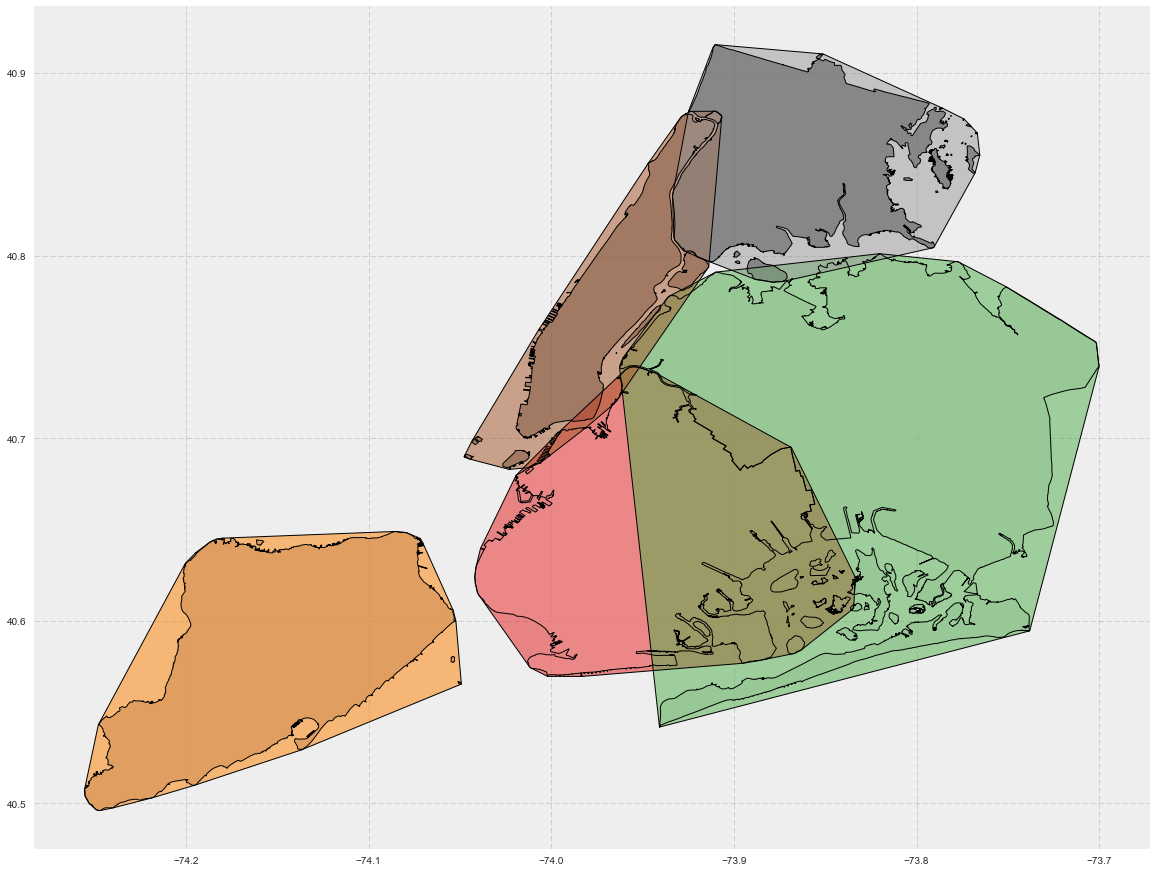

In [6]:
# create convex hulls
hulls = gdf['geometry'].convex_hull

# plot overlay
hulls.plot(ax=gdf.plot())

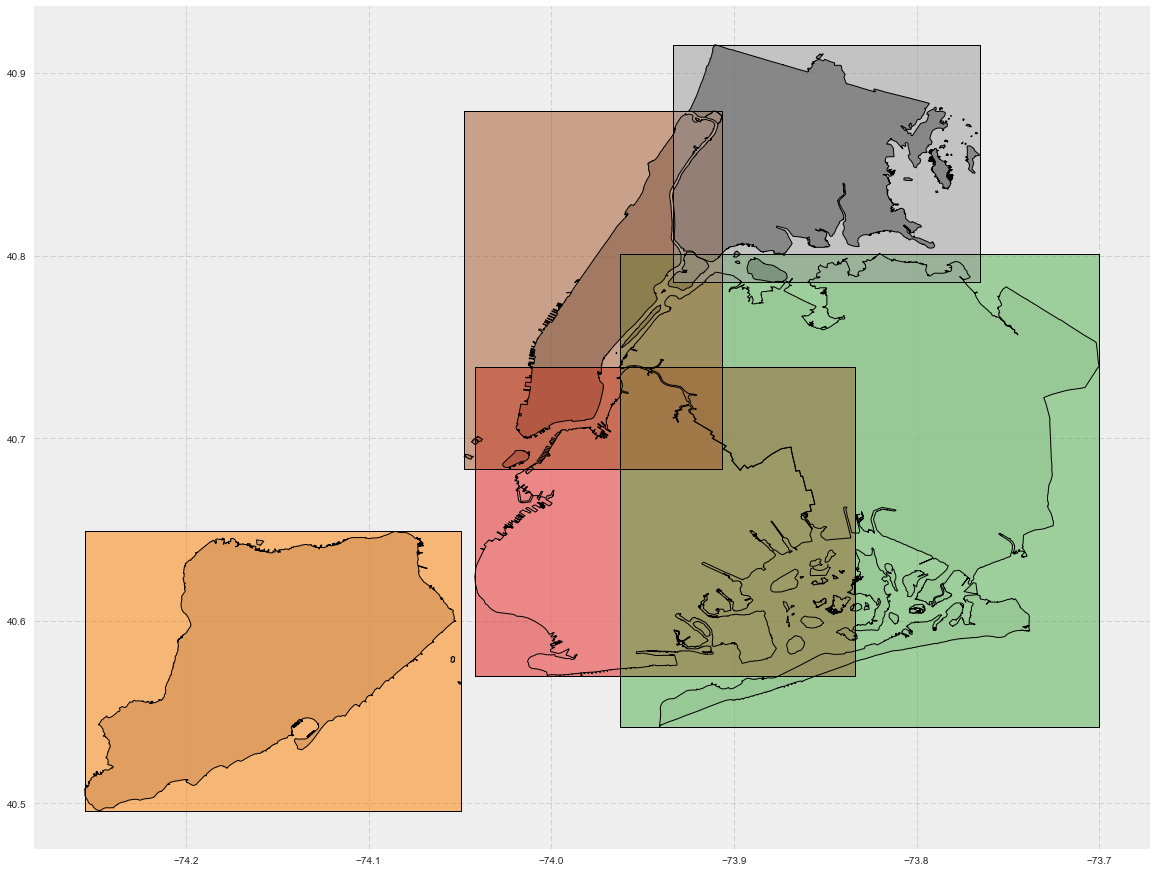

In [7]:
# create envelopes
envelope = gpd.GeoSeries(hulls.envelope)

# plot overlay
envelope.plot(ax=gdf.plot())

In this part, we'll quantify efficiency. While timing your code, check how long it takes for your computer to check:

- Whether or not each sample falls in the true geographic boroughs.
- Whether or not each sample falls in the convex hulls of the boroughs.
- Whether or not each sample falls in the envelopes of the boroughs.

(Check the linear algebra lesson on computational efficiency for commands for timing code.)

Report these numbers, as well as how much more efficient (percentage-wise) envelopes and convex hulls are relative to the true geographies.

In [ ]:
import time
start = time.time()

# check if point(s) fall within known geometry - actual
sim_data['contains_actual'] = sim_data['point'].map(lambda x: True if gdf.contains(x).any()==True else False)

finish = time.time()
elapsed_geo = finish - start
print 'Time elapsed: ', elapsed_geo

In [ ]:
import time
start = time.time()

# check if point(s) fall within known geometry - convex hulls
sim_data['contains_hulls'] = sim_data['point'].map(lambda x: True if hulls.contains(x).any()==True else False)

finish = time.time()
elapsed_hull = finish - start
print 'Time elapsed: ', elapsed_hull

In [ ]:
import time
start = time.time()

# check if point(s) fall within known geometry - envelopes
sim_data['contains_env'] = sim_data['point'].map(lambda x: True if envelope.contains(x).any()==True else False)

finish = time.time()
elapsed_env = finish - start
print 'Time elapsed: ', elapsed_env

In [ ]:
# Geo-actual vs hull
print 'Hull takes ', round(elapsed_hull / elapsed_geo * 100,2) , '% of the time it took to compute actual geographic areas'
print 'Envelope takes ', round(elapsed_env / elapsed_geo * 100,2) , '% of the time it took to compute actual geographic areas'


Obviously there's a trade-off here. Check how many samples lie in the actual geographies, the convex hulls, and the envelopes.

Report the following:

- A confusion matrix comparing convex hulls and actual geographies. (i.e. actual geographies are the true counts; convex hulls are predicted counts)
- A confusion matrix comparing envelopes and actual geographies.
- The accuracy, sensitivity, and specificity from each of the confusion matrices above.
- A paragraph summarizing your findings.

- Accuracy: Overall, how often is the classifier correct?
(TP+TN)/total = (100+50)/165 = 0.91
- Sensitivity: When it's actually yes, how often does it predict yes?
TP/actual yes = 100/105 = 0.95
- Specificity: When it's actually no, how often does it predict no?
TN/actual no = 50/60 = 0.83
equivalent to 1 minus False Positive Rate

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from __future__ import division
def cm_scores(predicted, pred_col_no, pred_col_yes):
    from IPython.display import display

    
    true = sim_data.contains_actual
    c_matrix = pd.DataFrame(confusion_matrix(true,
                                         predicted),columns=[pred_col_no,
                                                             pred_col_yes],index=['Not in Actual Area',
                                                                               'In Actual Area'])
    n = sim_data.shape[0]
    TP = c_matrix[pred_col_yes][1]
    TN = c_matrix[pred_col_no][0] 
    FN = c_matrix[pred_col_no][1]
    FP = c_matrix[pred_col_yes][0] 
    print 'Accuracy = ', (TP + TN) / n # how often is the classifier correct?
    print 'Sensitivity = ', TP / (TP + FN) # when in actual area, how often is it in predicted area?
    print 'Specificity = ', TN / (TN + FP) # when not in actual area, how often is it in predicted area?
    
    display(c_matrix)

In [ ]:
print 'Geographic Hulls'
cm_scores(sim_data.contains_hulls, 'Predicted Not in Hull', 'Predicted In Hull')

In [ ]:
print 'Geographic Envelopes'
cm_scores(sim_data.contains_env, 'Predicted Not in Envelope', 'Predicted In Envelope')

## Project 5 Component
Pivoting to Project 5, take the data for this project. Generate a map of the world with each country shaded based on the number of terror attacks that occur in each country. (Warning: Some data munging is likely necessary here.)

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
terror = pd.read_csv('/Users/jennydoyle/Desktop/dsi/04-project-assets/globalterrorismdb_0616dist.csv')

In [ ]:
fix_names = {'Dem. Rep. Korea':'South Korea',
'Korea':'North Korea',
'Czech Rep.':'Czech Republic',
'Bosnia and Herz.':'Bosnia-Herzegovina',
'Bosnia and Herzegovina':'Bosnia-Herzegovina',
'Central African Rep.': 'Central African Republic',
 'Dem. Rep. Congo':  'Congo',
'Lao PDR':'Laos',
'Slovakia':'Slovak Republic'}

world.name.replace(fix_names, inplace=True)

fix_countries = {'Democratic Republic of the Congo':'Congo',
"People's Republic of the Congo"  :'Congo',
'Republic of the Congo':'Congo',
'Dominica':'Dominican Rep.',
'Dominican Republic':'Dominican Rep.',
'Czechoslovakia': 'Czech Republic',
'East Germany (GDR)':'Germany',
'East Timor':'Timor-Leste', 
'Equatorial Guinea':'Eq. Guinea',                
'Falkland Islands':'Falkland Is.',
'Hong Kong':'China',
'North Yemen':'Yemen',
'Serbia-Montenegro':'Serbia',
'Solomon Islands':'Solomon Is.',
'South Sudan':'Sudan',
'South Vietnam':'Vietnam',
'South Yemen':'Yemen',
'Soviet Union':'Russia',
'West Germany (FRG)':'Germany',                 
'Western Sahara':'W. Sahara'}

terror.country_txt.replace(fix_countries, inplace=True)

In [ ]:
terror_grouped = terror.groupby('country_txt').count().reset_index()
terror_grouped = terror_grouped[['country_txt','eventid']]
terror_grouped.rename(columns={'eventid':'Num_Tattacks'},inplace=True)

world_terror = world.merge(terror_grouped, left_on='name', right_on='country_txt')

q10 = pysal.Quantiles(world_terror.Num_Tattacks,k=10)
f, ax = plt.subplots(1, figsize=(20,10))
world_terror.assign(cl=q10.yb).plot(column='Num_Tattacks', categorical=True, \
        cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', k=10, legend=True, scheme='DECILES')
ax.set_axis_off()
plt.show()

# http://darribas.org/gds_scipy16/ipynb_md/02_geovisualization.html

Suppose I want to forecast the number of terror attacks by country. Would this process be described as areal, geostatistical, or point pattern?

Build a widget that will put dots on the map for the location of each terror attack by year. Depending on how precisely you wish to identify the location of the terror attack, you may use the centroid of a country if you'd like. (Note: Using the centroid may cause multiple dots to overlap; people often use a [random jitter](https://www.dataplusscience.com/TableauJitter.html) to help with this. While not required for this lab, consider random jitter as a bonus!)

In [ ]:
# widget stuff
from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display



def make_plot(hour=1):

    # filter dataframe
    temp = sim_data[sim_data['contains_2']==True]
    temp=temp[temp['datetime'].dt.hour==hour]

    # plot
    hulls.plot(ax=gdf.plot())
    plt.scatter(x=temp['x'], y=temp['y'], s=30)

# create widget
interact(make_plot, hour=(1, 23, 1))

Suppose I want to predict the precise location of terror attacks. Would this process be described as areal, geostatistical, or point pattern?

In [ ]:
areal = 
geostatistical = continuous, weather
point pattern = specific areas

### If you're happy with the results here, you should consider including these in your presentations next week!